## NWB-Datajoint Artifact Removal Pipelines

**Note: make a copy of this notebook and run the copy to avoid git conflicts in the future**

This Notebook will import nwb file, pick a session/interval of data, and run get_fitlered_recording_extractor/get_traces. 

Then, visuazlize traces at different scales, pick some thresholds, and examine reuslts of artifact removal (what was removed?)

Let's start by importing the `nwb_datajoint` package, along with a few others. 

In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import os
import numpy as np
import datajoint as dj
import scipy.stats as stats
# dj.config['database.host'] = '127.0.0.1'
# dj.config['database.user'] = 'root'
# dj.config['database.password']= 'simple'

In [158]:
import nwb_datajoint as nd

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
os.environ['NWB_DATAJOINT_TEMP_DIR']="/stelmo/nwb/tmp"
os.environ['KACHERY_STORAGE_DIR']="/stelmo/nwb/kachery-storage"


In [159]:
# import tables so that we can call them easily
from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  SortGroup, SpikeSortingFilterParameters, SpikeSortingArtifactDetectionParameters,
                                  SpikeSortingRecordingSelection, SpikeSortingRecording, 
                                  SpikeSortingWorkspace, 
                                  SpikeSorter, SpikeSorterParameters, SortingID,
                                  SpikeSortingSelection, SpikeSorting, 
                                  SpikeSortingMetricParameters,
                                  ModifySortingParameters, ModifySortingSelection, ModifySorting, 
                                  AutomaticCurationParameters, AutomaticCurationSelection,
                                  AutomaticCuration,
                                  CuratedSpikeSortingSelection, CuratedSpikeSorting,
                                  UnitInclusionParameters,
                                  FirFilter,
                                  IntervalList, SortInterval,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery)

In [160]:
from nwb_datajoint.common import (get_valid_intervals)

### Define your nwb file

In [161]:
nwb_file_name = 'senor20201030_.nwb'


In [7]:
#maybe should make this cell all the parameters to change up front. 

Do you want to sort your data by electrode group or by shank? Probe data or tetrode data?

In [8]:
#Uncomment to set sort group- one or the other!!!


# SortGroup().set_group_by_electrode_group(nwb_file_name)

# #SortGroup().set_group_by_shank(nwb_file_name2)

#Want to understand how our sort groups are 
#can still do set_group_shank_groups()

Examine your sort group electrodes, will also give you the length of your sort group

In [162]:
# SortGroup.SortGroupElectrode & {'nwb_file_name': nwb_file_name}
SortGroup.SortGroupElectrode & {'sort_group_id': 1,'nwb_file_name' : nwb_file_name,}

/home/emonroe/miniconda2/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/connection.py:304: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
senor20201030_.nwb,1,1,4
senor20201030_.nwb,1,1,5
senor20201030_.nwb,1,1,6
senor20201030_.nwb,1,1,7


Examine your Sort group- will be helpful for seeing how many groups you have, what your reference electode is 

In [10]:
# SortGroup() & {'nwb_file_name' : nwb_file_name}
##ElectrodeGroup()

#### Define sort interval
Next, we make a decision about the time interval for our spike sorting. Let's re-examine `IntervalList`. This will reveal potential epoch level intervals

In [163]:
IntervalList & {'nwb_file_name' : nwb_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
senor20201030_.nwb,01_s1,=BLOB=
senor20201030_.nwb,02_r1,=BLOB=
senor20201030_.nwb,03_s2,=BLOB=
senor20201030_.nwb,04_r2,=BLOB=
senor20201030_.nwb,05_s3,=BLOB=
senor20201030_.nwb,06_r3,=BLOB=
senor20201030_.nwb,07_s4,=BLOB=
senor20201030_.nwb,08_r4,=BLOB=
senor20201030_.nwb,09_s5,=BLOB=
senor20201030_.nwb,10_r5,=BLOB=


For our example, let's choose the first [X] seconds of the first run interval (`02_r1`) as our sort interval. To do so, we first fetch `valid_times` of this interval, define our new sort interval, and add this to the `SortInterval` table.

In [197]:
interval_list_name = '06_r3'

valid intervals for the epoch and the length of session in seconds

In [196]:
interval_list = (IntervalList & {'nwb_file_name' : nwb_file_name,
                            'interval_list_name' : interval_list_name}).fetch1('valid_times')
print(interval_list)
total_time_s = interval_list[0][1]-interval_list[0][0] #total length of segment (s)

[[1.60407821e+09 1.60407941e+09]]


## define interval to visualize

Choose time from start, how many seconds into your segment, and how long you want your total session to be. 

In [181]:
time_from_start = 0 #Set if you want to start some time into interval
segment_length = total_time_s  #Total segment length

sort_interval = np.copy(interval_list[0]) 
sort_interval[1] = sort_interval[0]+time_from_start+segment_length #[X]
sort_interval[0] = sort_interval[0]+[time_from_start]
sort_interval_name = f'senor_{int(segment_length)}_seconds_{time_from_start}_from_start_epoch_{interval_list_name}'

#raw data times of interest

Can check your modified interval compared to original

In [182]:
# sort_interval
print(sort_interval[0])
print(sort_interval[1])
print(sort_interval[1]-sort_interval[0])
print(sort_interval_name)

1604086645.990357
1604087811.298697
1165.3083400726318
senor_1165_seconds_0_from_start_epoch_06_r3


Now, insert entry into SortInterval Table with name and interval 

In [179]:
# Specify the required attributes.
# This time, the entries take the form of a dictionary.
SortInterval.insert1({'nwb_file_name' : nwb_file_name,
                     'sort_interval_name' : sort_interval_name,
                     'sort_interval' : sort_interval}, replace=True)

In [180]:
# Check out SortInterval- your new entry should be there! But this cell will show all different sort intervals for the same nwb file
(SortInterval & {'nwb_file_name' : nwb_file_name})

nwb_file_name name of the NWB file,sort_interval_name name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
senor20201030_.nwb,artifact_test_1165.3083400726318_seconds_0_from_start,=BLOB=
senor20201030_.nwb,senor_1165.3083400726318_seconds_0_from_start,=BLOB=
senor20201030_.nwb,senor_1165_seconds_0_from_start,=BLOB=
senor20201030_.nwb,senor_1165_seconds_0_from_start_epoch_06_r3,=BLOB=


See the SortInterval table for the most recent sort interval name 

In [183]:
# See results
(SortInterval & {'nwb_file_name' : nwb_file_name, 'sort_interval_name': sort_interval_name})#.fetch1('sort_interval')

nwb_file_name name of the NWB file,sort_interval_name name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
senor20201030_.nwb,senor_1165_seconds_0_from_start_epoch_06_r3,=BLOB=


Now set the filtering parameters. Here we insert the default parameters and a new set of filtering parameters for hippocampal data
|

Filtering, entering parameters in table for hippocampal data aparently but should do filtering for cortex vs tetrode in the future!

In [185]:
SpikeSortingFilterParameters().insert_default()
filter_param_dict = SpikeSortingFilterParameters.fetch('filter_parameter_dict')
filter_param_dict = filter_param_dict[0]

In [186]:
filter_param_dict['frequency_min'] = 600
SpikeSortingFilterParameters().insert1({'filter_parameter_set_name': 'franklab_default_hippocampus', 
                                       'filter_parameter_dict' : filter_param_dict}, skip_duplicates=True)

Interestingly, for now, we just have to use No artifact parameters in the sort. Later, after we find the correct paramers to use explicitly, we can add them to the artifact table and test this next line, but with (get_no_artifact_times)

Similarly, we set up the SpikeSortingArtifactParameters which can allow us to remove artifacts from the data
For the moment we just set up a "none" parameter set which will do nothing when used

In [187]:
SpikeSortingArtifactDetectionParameters().insert_default()

Now we set up the parameters so we can get the recording extractor- Including: 
-Which sort group ID? 
-Your sort_interval_name
-Filter Parameters
-interval list
-lab team

This will just set up some variables for later use, possibly redundant for some

In [205]:
sort_group_id = 25 # use sort group 2
sort_interval_name = sort_interval_name
filter_param_name = 'franklab_default_hippocampus' #change for cortex
artifact_param_name = 'none'
interval_list_name = interval_list_name
lab_team = 'ac_em_xs'
#check lab teams table

Collect all relevant parameters in  key dictionary, also save a cope of this dictionary as ssr_key

In [207]:
# collect the params
key = dict()
key['nwb_file_name'] = nwb_file_name
key['sort_group_id'] = sort_group_id
key['filter_parameter_set_name'] = filter_param_name
key['sort_interval_name'] = sort_interval_name
key['artifact_parameter_name'] = artifact_param_name
key['interval_list_name'] = interval_list_name
key['team_name'] = lab_team

ssr_key = key

Check out ssr key, last check before inserting this into spike sorting recording selection tabel

In [208]:
ssr_key

{'nwb_file_name': 'senor20201030_.nwb',
 'sort_group_id': 25,
 'filter_parameter_set_name': 'franklab_default_hippocampus',
 'sort_interval_name': 'senor_1165_seconds_0_from_start_epoch_06_r3',
 'artifact_parameter_name': 'none',
 'interval_list_name': '06_r3',
 'team_name': 'ac_em_xs'}

Before and after- before you insert, your entry should not be here

In [209]:
#Probably dont need to do this? 
# SpikeSortingRecordingSelection() & {'nwb_file_name' : nwb_file_name}

now insert your ssr_key into parameters table basically for spike sorting

In [210]:
#Dont need to do this here!!
# SpikeSortingRecordingSelection.insert1(key, skip_duplicates=True)

In [211]:
#Dont need to do this here!!
#
#### SpikeSortingRecording.populate([(SpikeSortingRecordingSelection & ssr_key).proj()])

Now we need to populate the SpikeSortingWorkspace table to make this recording available via kachery

In [212]:
# SpikeSortingRecording() & {'nwb_file_name' : nwb_file_name}
#will prob need to get recording extractor out, is this the thing we want? 
#go back to source code, read through function definitions, make sure understand what tables are (spikesrotingrecording)- How tables are related

In [213]:
#This was my attmpt to get the recording extractor after spike sorting. Tricky bc of the way its saved. 

# recording_extractor_path = (SpikeSortingRecording() & {'nwb_file_name' : nwb_file_name}).fetch1('recording_extractor_object')
# type(recording_extractor_path)
# recording = recording_extractor_path['data']

# recording['h5_uri']

# type(recording)
# # data=recording.get_traces()
# recording_extractor_path

In [214]:
#begin here if you have already defined above and want to restart from fresh recording 

## get recording extractor

This is where you run the only function you will need to get the recording extractor to visualize your recording

In [215]:
recording = SpikeSortingRecording().get_filtered_recording_extractor(ssr_key)

Elapsed time for filtered recording extractor setup: 50.6862678527832 sec
Elapsed time for NWB recording extractor create from file: 8.350441217422485 sec


In [216]:
#Get the traces and save it as variable named data
data=recording.get_traces()
dataz = np.abs(stats.zscore(data, axis=1))

In [217]:
#delete this later on 
# data=data[1:15,]


In [218]:
shape = data.shape #porbably means (x electrodes, y samples) 
print(shape)
print(shape[1]/recording.get_sampling_frequency()) # how many seconds your recording interval is- IMPORTANT- change 20000 to 30000 depending on sampling rate - gut check

(32, 34959124)
1166.8866539001465


In [35]:
# # recording._timestamps


In [1]:
shape

NameError: name 'shape' is not defined

In [37]:
import matplotlib.pyplot as plt

# metadata for rat and day

In [38]:
rat = 'beans'
date = '20190718'
session = interval_list_name
segment = f'time from start = {time_from_start}, segment length = {segment_length}'

session_data = f'rat = {rat} day = {date} session = {interval_list_name} \nsegment = {segment}'

### Plot the amplitude and z score from every electrode to consider potential thresholds 

In [ ]:
%matplotlib inline
# for ix in range(shape[0]):
#     plt.figure()
#     data_1_row = data[ix,]
#     plt.plot(data_1_row)
#     plt.title(f'amplitude electrode {ix}\n {session_data}')
#     plt.ylabel('amplitude')
#     plt.xlabel('sample')
    
# ax.axvspan(1990, 2010, color="blue", alpha=0.3)
 # 

fig, axs = plt.subplots(int(shape[0]/2),2,figsize=(15,200), sharex=True)
fig.suptitle(f'amp and z score all electrodes. {session_data}')
for ix in range(0,int(shape[0]/2)):
#     plt.figure()
    amp_data_el = data[ix]
    zscore_data_el = dataz[ix]
    axs[ix,0].plot(amp_data_el)
    axs[ix,1].plot(zscore_data_el)
    axs[ix,0].set_title(f'amplitude electrode{ix}').set_fontsize(8)
    axs[ix,1].set_title(f'zscore electrode{ix}').set_fontsize(8)
#ugh hVing some problems with the title placement. like the idea of suplots too look at both z score and amplitude to decide thresholds. 
# fig.tight_layout()
# fig.subplots_adjust(top=1)

In [93]:
int(shape[0]/2)

48

## plot the signal from electrode in interactive, scrolling mode

Can choose some thresolds to plot on top too, or make data_1_row smaller in time

In [ ]:
%matplotlib widget
ix = 0 
plt.figure()
data_1_row = data[ix,]
plt.plot(data_1_row)
plt.title(f'electrode {ix},\n{session_data}')
plt.ylabel('amplitude')
plt.xlabel('sample')
thresh= 150
plt.hlines(thresh,0,len(data_1_row))
plt.hlines((-1*thresh),0,len(data_1_row))

### Artifact removal code from get_no_artifact times

In [41]:
######### Original code: 


#   if zscore_thresh <= 0 and amplitude_thresh <= 0:
#             return np.asarray([[recording._timestamps[0], recording._timestamps[recording.get_num_frames()-1]]])
       
#     #This is where the artifact detection and comparison to thresholds occurs. 
    
#     #use the specified window length (how long to zero out on either sde of the artifact based on sampling rate
        
#         half_window_points = np.round(
#             recording.get_sampling_frequency() * 1000 * zero_window_len / 2)
      
#     #User defines proportion of electrodes that have to be above threshold for it to be labeled artifact (but two diff versions of this?)
#     nelect_above = np.round(proportion_above_thresh * data.shape[0])
    
#         # get the data traces
#         data = recording.get_traces()

#         # compute the number of electrodes that have to be above threshold based on the number of rows of data
#         nelect_above = np.round(
#             proportion_above_thresh * len(recording.get_channel_ids()))

#         # apply the amplitude threshold (find when the data is above amplitude threshold)
#         above_a = np.abs(data) > amplitude_thresh

#         # zscore the data and get the absolute value for thresholding
#         dataz = np.abs(stats.zscore(data, axis=1))
#         above_z = dataz > zscore_thresh #find when datas z scare is above specified threshold
       
#     #not sure what ravel does. im guessing that it looks acrross electrodes(?) and finds when the sum of them being over thresh is bigger than neglect_above
#         above_both = np.ravel(np.argwhere(
#             np.sum(np.logical_and(above_z, above_a), axis=0) >= nelect_above))
#         valid_timestamps = recording._timestamps #not sure what this is doing yet.. why are these valid timesteps?
        
#         # for each above threshold point, set the timestamps on either side of it to -1
#         #So, have a list of valid timesteps, and set times that are "above both" plus or minus window points to negative 1...
#         for a in above_both:
#             valid_timestamps[a - half_window_points:a +
#                              half_window_points] = -1

#         #anything that is not -1 is now a valid timestamp,     
#         # use get_valid_intervals to find all of the resulting valid times.
#         #What is get_valid_intervals? Look into these other arguments 
#         #Go find get valid intervals 
#         return get_valid_intervals(valid_timestamps[valid_timestamps != -1], recording.get_sampling_frequency(), 1.5, 0.001)





## Choose artifact parameters 

In [42]:
skip = False 
zscore_thresh = 10 #
amplitude_thresh=150
proportion_above_thresh = .2 #proportion of total electrodes the artifact has to cross. 
zero_window_len= .000005 #How many seconds around each artifact to remove. Easier for me to think about samples (this *1000*samplijng rate)
#also arbitrary for now, but should go back and recalculate after detection 


param_dict = {} #empty dictionary called param_dict
param_dict['skip'] = skip
param_dict['zscore_thresh'] = zscore_thresh
param_dict['amplitude_thresh'] = amplitude_thresh
param_dict['proportion_above_thresh'] = proportion_above_thresh
param_dict['zero_window_len'] = zero_window_len # 1 ms at 30 KHz, but this is of course skipped

#we should define a variable called art_params that we can add to plots 

artifact_params = f'artifact params = z = {zscore_thresh} amp= {amplitude_thresh} prop = {proportion_above_thresh}'

#### This cell will return the number of samples to remove each side of artifact (in final intervals)- arbitrary for now

In [43]:
#We define how many total ms we want removed. Say, 1ms on each side of the artifact, so zero window length == .002s
#Half window points will convert our time into samples on either side of the artifact. 
#.002 s
#Times 1000 = 2ms
#/2 = 1 ms
#*sampling frequency =~20,000 = 20,000 samples to be removed on either side of artifact 
# = half window points

half_window_points = np.round(recording.get_sampling_frequency() * 1000 * zero_window_len / 2)


print(half_window_points) #how many samples of data around each artifact (per side) to be removed
print(half_window_points/(recording.get_sampling_frequency()*1000)) # = how many s of data around each artifact will be removed


50.0
2.503395080566406e-06


#### Number electrodes that must cross threshold for each artifact , done it two different ways (by data, or by original recording)

In [44]:
nelect_above = np.round(proportion_above_thresh * data.shape[0])
# print(nelect_above)
print(nelect_above)

19.0


In [45]:
# nelect_above = np.round(proportion_above_thresh * len(recording.get_channel_ids()))
print(nelect_above)

19.0


### find when amplitude crosses thresh

In [46]:
above_a = np.abs(data) > amplitude_thresh
print(above_a)


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [47]:
##will plot raw amplitude for chose electroden overlaid with the signal at found artifact times 

# %matplotlib inline
# electrode = 1
# plt.plot(data[electrode],label='raw')
# plt.plot(above_a[electrode]*data[electrode], label='artifact only*raw')
# plt.hlines(amplitude_thresh,0,len(data[0]))
# plt.xlabel('samples')
# plt.ylabel('amplitude')
# plt.legend(loc="lower right")
# plt.title(f'artifact times (0/1) * raw for electrode {electrode}\n rat = {rat}\ndate={date}\nsession={session}\ninterval:{segment}')

#### find when z score crosses thresh

In [48]:
dataz = np.abs(stats.zscore(data, axis=1))
above_z = dataz > zscore_thresh #find when datas z scare is above specified threshold
# print(dataz)
# print(above_z)

 
## Find indexes where both amplitude and z score cross thresholds
#### valid timestamps gets all timestamps from recording

In [49]:
#above both: find when above z and above a are both true. Then, sum across electrodes for each sample. Find when sum > number electrodes. get array of array of timestamps. then ravel them into 1 array
above_both = np.ravel(np.argwhere(np.sum(np.logical_and(above_z, above_a), axis=0) >= nelect_above))
valid_timestamps = recording._timestamps #not sure what this is doing yet.. why are these valid timesteps?
above_both

array([ 223839,  223840,  230775,  368039, 1019493, 1031364, 1090675,
       1173293, 1242141, 1242142, 1644722, 1858867, 1858868, 1997065])

In [50]:
# #scatter of artifact number vs time- to see when the artifacts happen
# %matplotlib inline
# plt.figure()
# plt.scatter(range(len(above_both)),above_both)
# plt.title('find the times when artifact is detected \n note how they are often back to back')
# plt.xlabel('artifact number')
# plt.ylabel('time')

### turn range around artifact time into -1's in valid timestamps

In [51]:
for a in above_both:
    valid_timestamps[int(a - half_window_points):int(a + half_window_points)] = -1
#Section for vizualizing/ examining timestamps below!!

In [52]:
# find and return valid intervals. Not as useful for quantifying artifact 

# get_valid_intervals(valid_timestamps[valid_timestamps != -1], recording.get_sampling_frequency(), 1.5, 0.001)

In [53]:
#This will be useful when splitting up notebook into parts- savehe variabes

# ix=0
# electrode_example = data[ix,]
# %store electrode_example

# Plotting/ visualization

### Plot the amplitude for 1 electrode with artifact times (including surrounding window)highlighted in red 

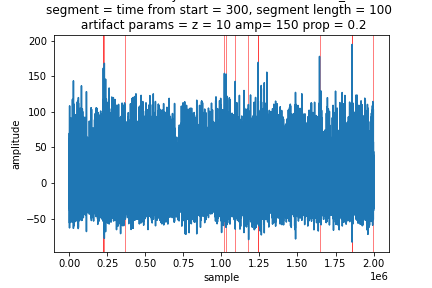

In [54]:
# %matplotlib inline
%matplotlib widget


ix = 0 #which electrode you would like to plot
plt.figure()
data_1_row = data[ix,]
plt.plot(data_1_row)
plt.title(f'electrode {ix},\n{session_data} \n {artifact_params}')
plt.ylabel('amplitude')
plt.xlabel('sample')
for a in above_both:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)
# plt.hlines(amplitude_thresh,0,650000)
# plt.hlines(-1*amplitude_thresh,0,650000)

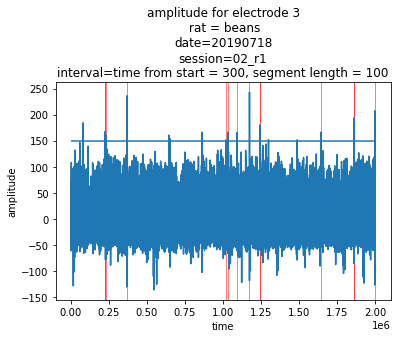

In [55]:
#Do the same with different plot style, easier to see which parts are detected and which are not
#wanted to highlight times when just amp thresh crossed but have to make into intervals. 
%matplotlib inline
plt.figure()
electrode = 3 #pick electrode
plt.plot(data[electrode])
plt.title(f'amplitude for electrode {electrode}\n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.hlines(amplitude_thresh,0,len(dataz[0]))
for a in above_both:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5, label='detected artifact times')




### Plot z score for 1 electrode

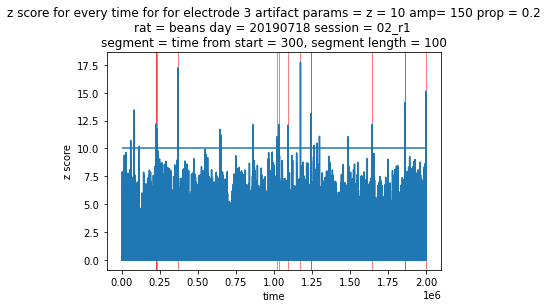

In [56]:
#% matplotlib inline
electrode = 3
plt.figure()
plt.plot(dataz[electrode])
plt.title(f'z score for every time for for electrode {electrode} {artifact_params}\n{session_data}')
plt.xlabel('time')
plt.ylabel('z score')
plt.hlines(zscore_thresh,0,len(dataz[0]))
# plt.plot(above_z[electrode]*dataz[electrode], color = 'black', label = 'detected z score threshold crossings')
# plt.legend()
for a in above_both:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)


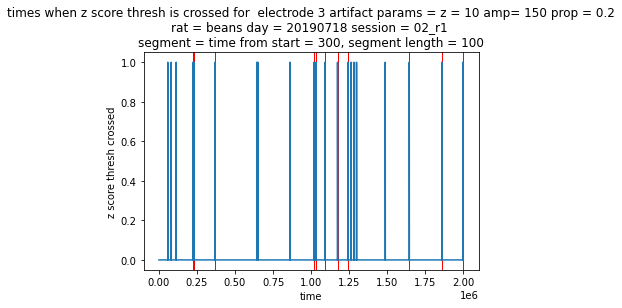

In [57]:
#plots only 0s and 1s for times when threshold was crossed

plt.figure()
plt.plot(above_z[electrode])


plt.title(f'times when z score thresh is crossed for  electrode {electrode} {artifact_params}\n{session_data}')
plt.xlabel('time')
plt.ylabel('z score thresh crossed')
#can plot only the final ones here too
for a in above_both:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', label='detected artifact times')

In [ ]:

fig, axs = plt.subplots(int(shape[0]/2),2,figsize=(15,200), sharex=True)
# fig.suptitle(f'amp and z score all electrodes. {session_data}')
for ix in range(0,int(shape[0]/2)):
#     plt.figure()
    amp_data_el = data[ix]
    zscore_data_el = dataz[ix]
    axs[ix,0].plot(amp_data_el)
    for a in above_both:
        axs[ix,0].axvspan(int(a - half_window_points),int(a + half_window_points), color='red', label='detected artifact times')
    axs[ix,1].plot(zscore_data_el)
    for a in above_both:
        axs[ix,1].axvspan(int(a - half_window_points),int(a + half_window_points), color='red', label='detected artifact times')
    axs[ix,0].set_title(f'amplitude electrode{ix}').set_fontsize(8)
    axs[ix,1].set_title(f'zscore electrode{ix}').set_fontsize(8)
    axs[ix,0].axhline(amplitude_thresh,0,len(data[ix]))
    axs[ix,1].axhline(zscore_thresh,0,len(dataz[ix]))


    
        # ax.axvspan(1990, 2010, color="blue", alpha=0.3)


#ugh hVing some problems with the title placement. like the idea of suplots too look at both z score and amplitude to decide thresholds. 
# fig.tight_layout()
# fig.subplots_adjust(top=1)

## plot the histogram for amplitude and z score for 1 electrode, then all electrodes overlapping

#### can change number of bins in hists too

Text(0.5, 1.0, 'histogram of all amplitudes for electrode 3 \n artifact params = z = 10 amp= 150 prop = 0.2\n rat = beans day = 20190718 session = 02_r1 \nsegment = time from start = 300, segment length = 100\n  bin width = 5')

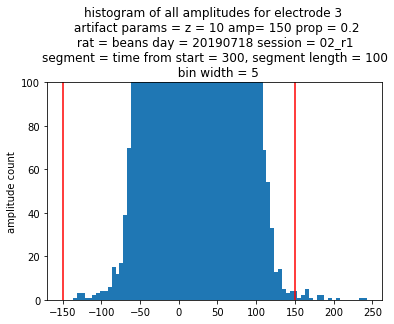

In [58]:
#hist of 1 electrodes amplitude counts. Important- turn on and off ylim/change values. 
import math

plt.figure()
electrode = 3
# plt.hist(data[electrode])
plt.ylim(0,100)
plt.ylabel('amplitude count')
plt.vlines(amplitude_thresh,0,1000000, color='red')
plt.vlines(-1*amplitude_thresh,0,1000000, color='red')
w = 5
n = math.ceil((data[electrode].max() - data[electrode].min())/w) #number of bins
ax = plt.hist(data[electrode], bins = n)
plt.title(f'histogram of all amplitudes for electrode {electrode} \n {artifact_params}\n {session_data}\n  bin width = {w}')



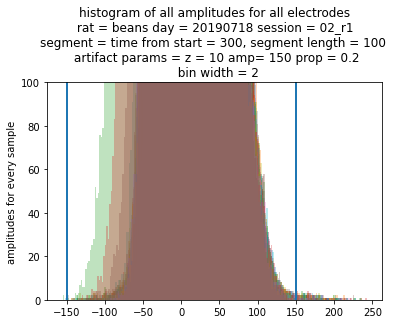

In [59]:
#histogram each electrodes amplitude profile, with all electrodes overlaied. 
#Problems (because they arent summed accross electrodes)- I want them to be summed, because then we can see then events of simlar large size span multiple electrodes
plt.figure()
for ix in range(0,96):
    # plt.figure()
    # plt.hist(data[ix], alpha=.3)
    plt.ylim(0,100)
    plt.ylabel('amplitudes for every sample')
    plt.vlines(amplitude_thresh,0,1000)
    plt.vlines(-1*amplitude_thresh,0,1000)
    w = 2
    n = math.ceil((data[ix].max() - data[ix].min())/w) #number of bins
    ax = plt.hist(data[ix], bins = n, alpha =.3)
    plt.title(f'histogram of all amplitudes for all electrodes\n {session_data} \n {artifact_params}\n  bin width = {w}')



### plot z score counts for 1 electrode

Text(0.5, 1.0, 'histogram of zscores for electrode 3\n rat = beans day = 20190718 session = 02_r1 \nsegment = time from start = 300, segment length = 100 \n artifact params = z = 10 amp= 150 prop = 0.2\n  bin width = 2')

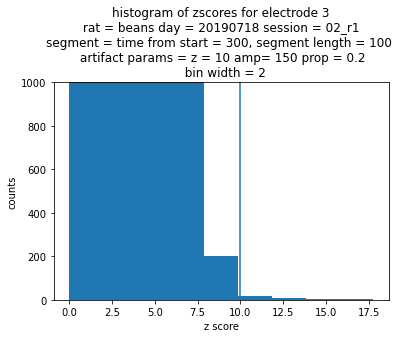

In [60]:
%matplotlib inline
plt.figure()
# plt.hist(dataz[electrode])
plt.vlines(zscore_thresh,0,1000)
plt.ylim(0,1000)
plt.xlabel('z score')
plt.ylabel('counts')
w = 2
n = math.ceil((dataz[electrode].max() - dataz[electrode].min())/w) #number of bins
ax = plt.hist(dataz[electrode], bins = n)
plt.title(f'histogram of zscores for electrode {electrode}\n {session_data} \n {artifact_params}\n  bin width = {w}')



In [61]:
#trying to center the bins by using a bar chart, but takes too much processing
# labels, counts = np.unique(dataz[electrode], return_counts=True)
# plt.bar(labels, counts, align='center')
# plt.gca().set_xticks(labels)
# plt.show()

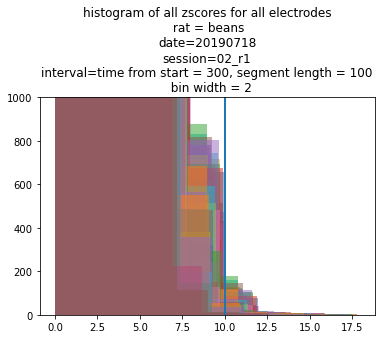

In [62]:
#this will plot all of the z score counts from all electrode overlaid. 
plt.figure()
for ix in range(0,96):
    # plt.figure()
    # plt.hist(dataz[ix],alpha=.5)
    plt.vlines(zscore_thresh,0,1000)
    plt.ylim(0,1000)
    w = 2
    n = math.ceil((dataz[ix].max() - dataz[ix].min())/w) #number of bins
    ax = plt.hist(dataz[ix], bins = n, alpha=.5)
    plt.title(f'histogram of all zscores for all electrodes\n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\n  bin width = {w}')


#add 


In [63]:
# #Here, I did something maybe not as useful, which was to concatenate all the data to plot in a single hist

# data_shorter = data[:,:]
# data_shorter.shape
# data_conc = np.concatenate(data_shorter)
# data_conc.shape
# data_shorter[1,0:15]
# data_conc[200000:200015]

# plt.hist(data_conc)
# plt.title(f'all electrodes concatenated, amplitude, \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}')
# plt.ylim(0,200)

# #Change bin sizes for histogram
# import math
# w = 1
# n = math.ceil((data_conc.max() - data_conc.min())/w) #number of bins
# ax = plt.hist(data_conc, bins = n)
# plt.ylim(0,100)
# plt.title(f'all electrodes concatenated, amplitude, \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\n bin width = {w}')
# plt.xlabel('amplitude')
# plt.ylabel('count')

# dataz_conc = np.concatenate(dataz)
# w = 5
# n = math.ceil((dataz_conc.max() - dataz_conc.min())/w) #number of bins
# ax = plt.hist(dataz_conc, bins = n)
# plt.ylim(0,4000)
# plt.title(f'all electrodes concatenated, z score, \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\n bin width = {w}')
# plt.xlabel('z score')
# plt.ylabel('count')

### Check how many samples are being removed, plot when valid timestamps = 0

In [64]:
# #Look at the first artifact time/index
# a = above_both[0]
# a
# #What index before artifact was turned to 0? 
# print(a - half_window_points)
# #What index after? 
# print(a + half_window_points)
# # how many total samples around the artifact were turned to -1 
# total_samples_removed_check= (a + half_window_points) - (a - half_window_points)
# print(total_samples_removed_check)
# #can print the timestamps around a sample to confirm expected -1s and surrounding data
# # valid_timestamps[int(a - half_window_points)-10:int(a + half_window_points)+10]
# #This gives 23 -1s, which is good news (almost) bc there are 4 timestamps back to back, and then 10 timestamps before and after them are -1'd out also.

# #Plots the invalid timestamps. #Should plot these on original. 

# plt.figure()
# plt.plot(valid_timestamps)
# # plt.title('plotting valid timestamps.. negative peaks are where timestamps have been set to -1')
# plt.figure()
# plt.plot(valid_timestamps==-1)
# # plt.title('plotting when timestamps == -1, just to confirm above plots title is true') 



## Look at data across electrodes, with highlighted artifact times. (amp and z score)
#### useful for looking at events that span electrodes that arent being included in final artifacts

In [ ]:
#This will plot the original raw amplitude for multiple electrodes, (can set), with when the artifact was detected(0,1) * raw amplitude. 
#visualize the artifacts on original data

#now done in subplots above. 


# for ix in range(0,10):
#     plt.figure()
#     plt.plot(data[ix])
#     plt.hlines(amplitude_thresh,0,len(data[0]))
#     for a in above_both:
#         plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)
#     plt.title(f'raw amplitude electrode{ix}, red = artifact times \n {session_data} \n {artifact_params}')
#     plt.xlabel('time')
#     plt.ylabel('amplitude')



In [101]:
# fig, axs = plt.subplots(shape[0],2,figsize=(15,200), sharex=True)
# for ix in range(0,shape[0]):
# #     plt.figure()
#     amp_data_el = data[ix]
#     zscore_data_el = dataz[ix]
#     axs[ix,0].plot(amp_data_el)
#     axs[ix,1].plot(zscore_data_el)
#     axs[ix,0].set_title(f'amplitude electrode{ix}').set_fontsize(8)
#     axs[ix,1].set_title(f'zscore electrode{ix}').set_fontsize(8)
#     # ax.axvspan(1990, 2010, color="blue", alpha=0.3)



In [102]:
# #This will plot the original raw z score for multiple electrodes, (can set), with when the artifact was detected(0,1) * zscore. 
# it used to be useful but now im doing both amp and z score in one plot 
# #visualize the artifacts on original data
# for ix in range(0,10):
#     plt.figure()
#     plt.plot(dataz[ix])
#     plt.hlines(zscore_thresh,0,len(dataz[0]))
#     for a in above_both:
#         plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)
#     plt.title(f'z score electrode{ix}, red = artifact times \n {session_data} \n {artifact_params}')

### Plot data only where timestmpas are valid (completely removing artifacts). Maybe not as useful. 

In [95]:
#Plot one example of the data remaining after the timestmap removal, with threshold - z score 

# plt.plot(dataz[0][valid_timestamps!=-1])
# plt.hlines(zscore_thresh,0,len(dataz[0]))

In [96]:
#plot every electrodes z scored data after timestamp revmoal
#
# for ix in range(0,14):
#     plt.figure()
#     plt.plot(dataz[ix][valid_timestamps!=-1])
#     plt.hlines(zscore_thresh,0,len(dataz[ix]))

In [97]:
#plot every electrodes amplitude with threshold after timestamp removal 
# for ix in range(0,14):
#     plt.figure()
#     plt.plot(data[ix][valid_timestamps!=-1])
#     plt.hlines(amplitude_thresh,0,len(data[ix]))

# Begin characterizing much smaller time scales around artifacts, across electrodes

In [ ]:
#This will plot all artifacts on 1 electrode

electrode = 0 

for ix in range(len(above_both)):
    #plt the 100 points on either side of the artifact
    plt.figure()
    data_sample = data[electrode,(above_both[ix]-100):(above_both[ix]+100)]
    plt.plot(data_sample)
    plt.xlabel('samples around artifact time')
    plt.ylabel('amplitude')
    plt.title(f'amplitude 200 samples around each detected artifact time \n {session_data} \n {artifact_params} electrode{electrode}')

In [ ]:
# I would like t o look at rate of change of artifacts 

In [104]:
electrode = 0 
ix=0
data_sample = data[electrode,(above_both[ix]-100):(above_both[ix]+100)]


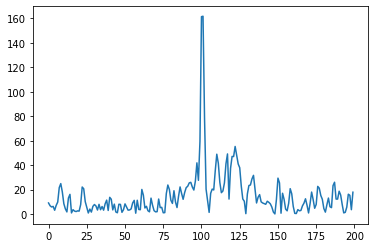

In [107]:
plt.plot(abs(data_sample))

In [ ]:
electrode = 0 

for ix in range(len(above_both)):
    #plt the 100 points on either side of the artifact
    plt.figure()
    data_sample = data[electrode,(above_both[ix]-100):(above_both[ix]+100)]
    roc=[]
    for sample in range(len(data_sample)):
        if sample< len(data_sample)-1:
            roc.append(data_sample[sample+1] - data_sample[sample])
    plt.plot(roc)
    plt.title('rate of change amplitude around artifact')
    plt.xlabel('sample')
    plt.ylabel('roc of amp')
    # plt.plot(data_sample)
    # plt.xlabel('samples around artifact time')
    # plt.ylabel('amplitude')
    # plt.title(f'amplitude 200 samples around each detected artifact time \n {session_data} \n {artifact_params} electrode{electrode}')

In [122]:
#just one
# roc=[]
# for sample in range(len(data_sample)):
#     if sample< len(data_sample)-1:
#         roc.append(data_sample[sample+1] - data_sample[sample])

Text(0, 0.5, 'roc of amp')

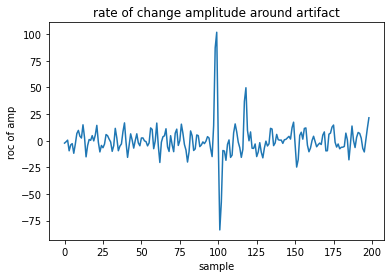

In [123]:
# plt.plot(roc)
# plt.title('rate of change amplitude around artifact')
# plt.xlabel('sample')
# plt.ylabel('roc of amp')

In [114]:
#this will do all data for an electrode
# roc=[]
# for sample in range(len(data[0])):
#     if sample< len(data[0])-1:
#         roc.append(data[0][sample+1] - data[0][sample])

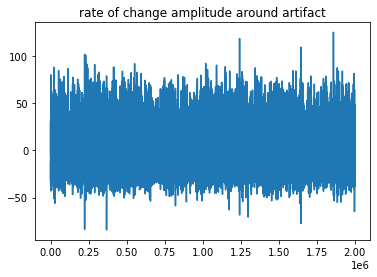

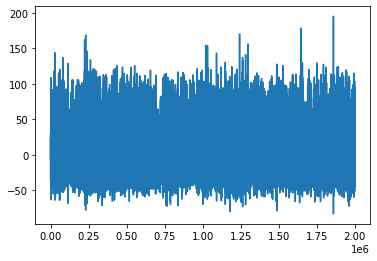

In [117]:
# plt.plot(roc)

# plt.title('rate of change amplitude around artifact')
# plt.figure()
# plt.plot(data[0])

In [ ]:
#(would be nice to look at the events that crossed thresh that werent counted as artifact)

In [125]:
#still want to do this. lets give it a try. 
above_a1= data[0]>=amplitude_thresh
above_z1=dataz[0]>=zscore_thresh
above_both1 = np.ravel(np.argwhere(np.logical_and(above_z1, above_a1)))


In [126]:
print(above_both1)

[ 223839  223840  230775 1019493 1031364 1242141 1242142 1298275 1644722
 1858867 1858868]


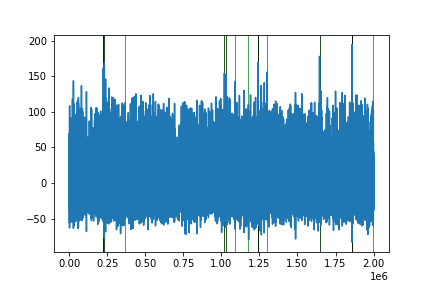

In [135]:
%matplotlib widget
plt.plot(data[0])
for a in above_both:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='green', alpha=0.7)
for a in above_both1:
    plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='black', alpha=0.5)
    

In [136]:
on1_not_all = list(set(above_both1) - set(above_both)) 

In [141]:
on1_not_all[0] # can ask should this one have been inlcuded?

1298275

In [137]:
on_all_not1=list(set(above_both) - set(above_both1))
on_all_not1 #can ask if these look like artifacts on single elctrode?

[1997065, 1090675, 1173293, 368039]

Text(0.5, 1.0, 'event detected on 1 electrode, but not included overall, amplitude 200 seconds around \n rat = beans day = 20190718 session = 02_r1 \nsegment = time from start = 300, segment length = 100 \n artifact params = z = 10 amp= 150 prop = 0.2 electrode 0')

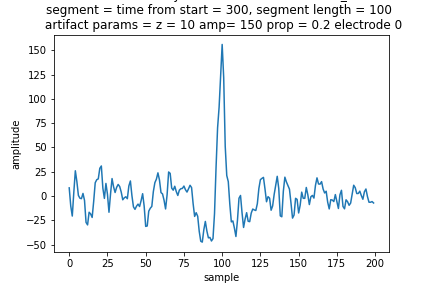

In [143]:
plt.figure()
data_sample = data[0,(on1_not_all[0])-100:(on1_not_all[0])+100]
plt.plot(data_sample)
plt.xlabel('sample')
plt.ylabel('amplitude')
plt.title(f'event detected on 1 electrode, but not included overall, amplitude 200 seconds around \n {session_data} \n {artifact_params} electrode 0')


In [ ]:
for ix in range(len(on_all_not1)):
    plt.figure()
    data_sample = data[0,(on_all_not1[ix])-100:(on_all_not1[ix])+100]
    plt.plot(data_sample)
    plt.xlabel('sample')
    plt.ylabel('amplitude')
    plt.ylim(-50,150)
    plt.title(f'event detected on all. but not on this electrode, amplitude 200 seconds around \n {session_data} \n {artifact_params} electrode 0, artifact {ix}')



In [ ]:
#what does the one detected on electrode 0 look like accross other electrodes? 
on1_not_all
%matplotlib inline
for ix in range((shape[0])):
    data_sample = data[ix,(on1_not_all[0])-100:(on1_not_all[0])+100]
    plt.figure()
    plt.plot(data_sample)
    plt.ylim(-75,160)
    plt.hlines(amplitude_thresh,0,len(data_sample))
    plt.title(f'artifact detected on 1 electrode, but not overall. what does it look like on the rest? electrode {ix} \n{artifact_params}\n{session_data}')



### Make a histogram of data within the sample around artifact. What within the shorter sample is normal vs unusual? 1 electrode, all artifacts

In [ ]:

for ix in range(len(above_both)):
    #plt the 100 points on either side of the artifact
    plt.figure()
    data_sample = data[electrode,(above_both[ix]-100):(above_both[ix]+100)]
    w = 1
    n = math.ceil((data_sample.max() - data_sample.min())/w) #number of bins
    plt.hist(data_sample,bins=n)
    plt.xlabel('amplitude')
    plt.ylabel('count of samples with amplitude')
    plt.title(f'amplitude counts 200 seconds around detected artifact time \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\nelectrode{electrode}, artifact sample = {above_both[ix]}\nbins width={w}')

## Now look at 1 artifact on all electrodes (amp & zscore)

### nice to see how much time around each artifact should be removed

In [ ]:
artifact = 6

for ix in range(data.shape[0]):
    #plt the 100 points on either side of the artifact
    plt.figure()
    data_sample = data[ix,(above_both[artifact]-200):(above_both[artifact]+200)]
    plt.plot(data_sample)
    plt.xlabel('samples areound artifact time')
    plt.hlines(amplitude_thresh,0,len(data_sample))
    plt.ylabel('amplitude')
    plt.title(f'amplitude 200 seconds around 1 artifact time on each electrode \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\nelectrode{ix}, artifact sample = {above_both[artifact]}')

In [ ]:
#Look at z score surrounding artifact on each electrode: 
artifact = 6

for ix in range(dataz.shape[0]):
    #plt the 100 points on either side of the artifact
    plt.figure()
    data_sample = dataz[ix,(above_both[artifact]-200):(above_both[artifact]+200)]
    plt.plot(data_sample)
    plt.xlabel('samples areound artifact time')
    plt.hlines(zscore_thresh,0,len(data_sample))
    plt.ylabel('zscore')
    plt.title(f'zscore 200 seconds around 1 artifact time on each electrode \n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}\nelectrode{ix}, artifact sample = {above_both[artifact]}')

### Look at the amplitude of each artifact on each electrode. 
#### Each plot is 1 artifact, with each point being the amplitude on electrode

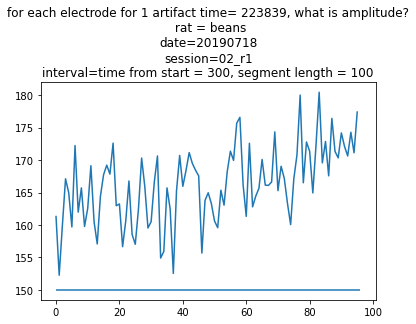

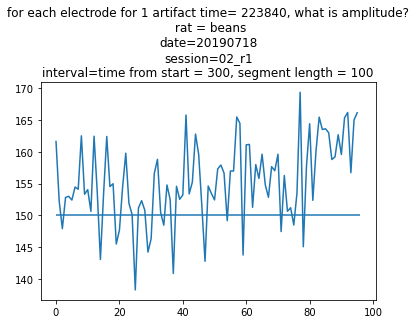

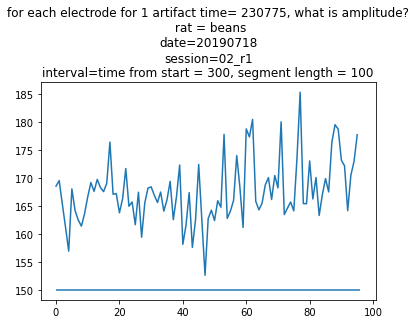

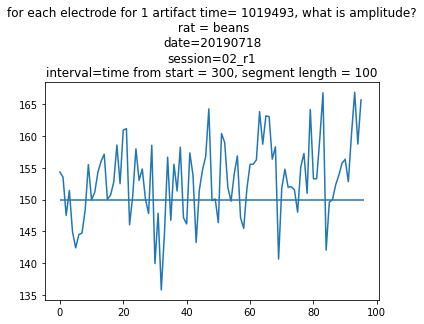

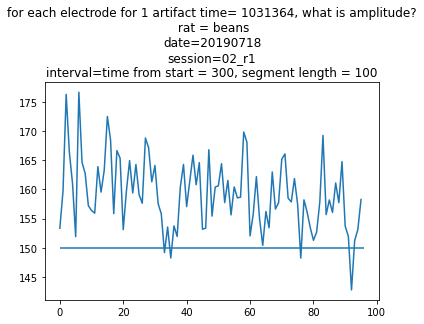

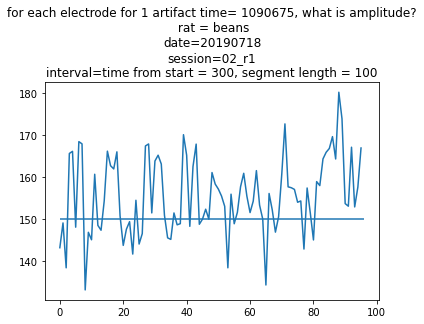

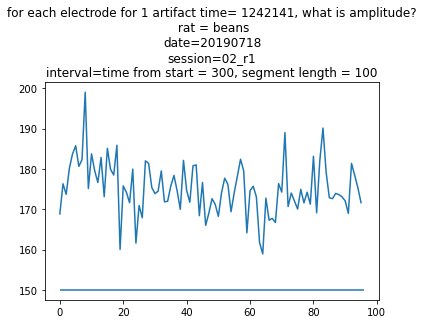

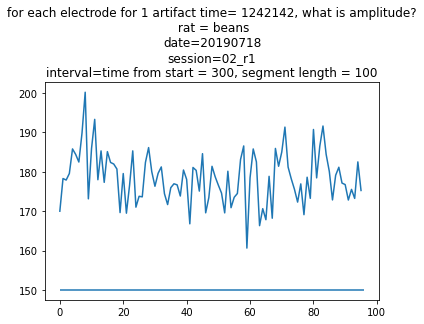

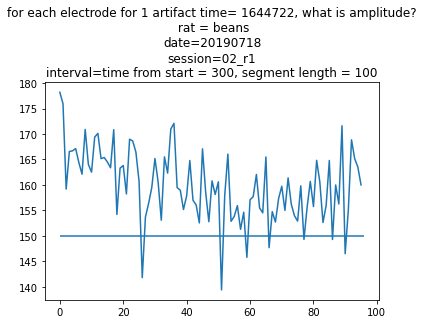

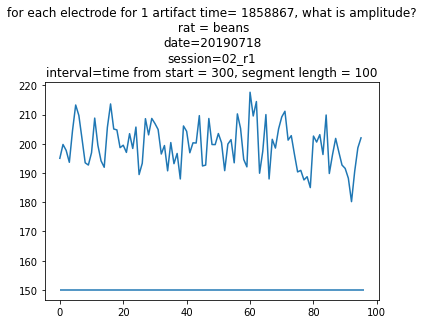

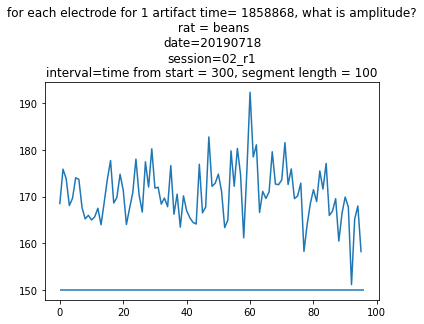

In [76]:
#look at amplitudes on electrodes at artifact time. get a plot for each artifact with the amplitude on each electrode at the artifact time. 
#Visualize how many electrodes crossed the amplitude thresh at artifact time 
for artifact in range(len(above_both)):
    amp_on_electrode=[]
    plt.figure()
    for ix in range(data.shape[0]):
        #plt the 100 points on either side of the artifact
        amp_on_electrode.append(data[ix,above_both[artifact]])

        #data_sample = data[ix,(above_both[artifact]-100):(above_both[artifact]+100)]
    plt.plot(amp_on_electrode)
    plt.hlines(amplitude_thresh,0,len(amp_on_electrode))

    plt.title(f'for each electrode for 1 artifact time= {above_both[artifact]}, what is amplitude?\n rat = {rat}\ndate={date}\nsession={session}\ninterval={segment}')      

### For every detected artifact, how many electrodes did the amplitude cross threshold? (what proportion)

In [78]:
#for every artifact, how many electrodes cross thresh at artifact time?
artifact_prop_el_x_thresh=[]
for artifact in range(len(above_both)):
    amp_on_electrode=[]
    for ix in range(data.shape[0]):
            #plt the 100 points on either side of the artifact
        amp_on_electrode.append(data[ix,above_both[artifact]])
        amp_greater=[]
        for ind in range(len(amp_on_electrode)):
            if abs(amp_on_electrode[ind]) >= amplitude_thresh:
                amp_greater.append(1)
            else:
                amp_greater.append(0)
    artifact_prop_el_x_thresh.append(sum(amp_greater)/len(amp_greater))

Text(0, 0.5, 'proportion of electrodes that cross amp thresh')

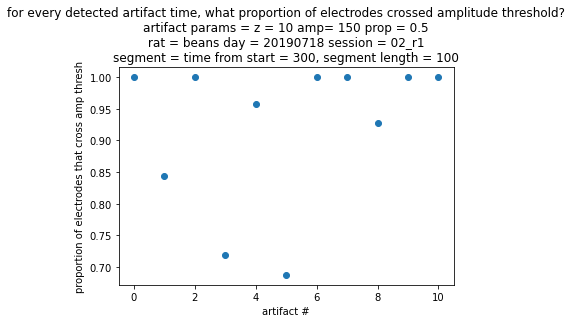

In [83]:
plt.scatter(range(len(artifact_prop_el_x_thresh)),artifact_prop_el_x_thresh)
plt.title(f'for every detected artifact time, what proportion of electrodes crossed amplitude threshold?\n{artifact_params}\n {session_data}')
plt.xlabel('artifact #')
plt.ylabel('proportion of electrodes that cross amp thresh')

In [84]:
#same but for z score 
artifact_prop_el_x_zthresh=[]
for artifact in range(len(above_both)):
    z_on_electrode=[]
    for ix in range(data.shape[0]):
            #plt the 100 points on either side of the artifact
        z_on_electrode.append(dataz[ix,above_both[artifact]])
        z_greater=[]
        for ind in range(len(z_on_electrode)):
            if z_on_electrode[ind] >= zscore_thresh:
                z_greater.append(1)
            else:
                z_greater.append(0)
    artifact_prop_el_x_zthresh.append(sum(z_greater)/len(z_greater))

Text(0, 0.5, 'proportion of electrodes that x z thresh')

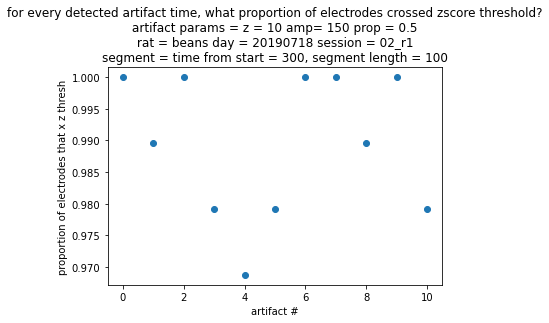

In [86]:
plt.scatter(range(len(artifact_prop_el_x_zthresh)),artifact_prop_el_x_zthresh)
plt.title(f'for every detected artifact time, what proportion of electrodes crossed zscore threshold?\n {artifact_params} \n {session_data}')
plt.xlabel('artifact #')
plt.ylabel('proportion of electrodes that x z thresh')

# info about removed artifact

## ideally should be saved to a table or somehting, metrics about the chosen artifact parameters

Text(0, 0.5, 'amplitude')

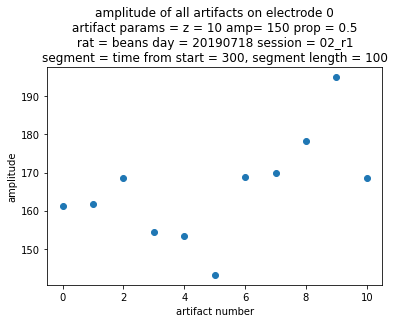

In [93]:
#can ask for every artifact, what is its size on all electrodes? 
electrode = 0
all_artifact_el_0=[]
for ix in range(len(above_both)):
    amplitude = data[electrode,above_both[ix]]
    all_artifact_el_0.append(amplitude)
plt.figure()
plt.scatter(range(len(all_artifact_el_0)),all_artifact_el_0)
plt.title(f'amplitude of all artifacts on electrode {electrode}\n {artifact_params} \n {session_data}')
plt.xlabel('artifact number')
plt.ylabel('amplitude')

Text(0.5, 1.0, 'zscore of all artifacts on electrode 0\n artifact params = z = 10 amp= 150 prop = 0.5 \n rat = beans day = 20190718 session = 02_r1 \nsegment = time from start = 300, segment length = 100')

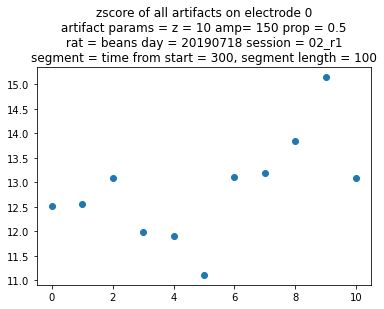

In [94]:
electrode = 0
all_zscore_el_0=[]

# for electrode in range(data.shape[0]):
for ix in range(len(above_both)):
    zscore = dataz[electrode,above_both[ix]]
    all_zscore_el_0.append(zscore)
plt.figure()
plt.scatter(range(len(all_zscore_el_0)),all_zscore_el_0)
plt.title(f'zscore of all artifacts on electrode {electrode}\n {artifact_params} \n {session_data}')

In [95]:
#can find average amp of all artifacts on 1 electrode, or can find average of all electrodes at artifact time. 
#can find average of all artifacts on all electrodes- get 1 value. 
#same with z score
all_zscore_el_0

[12.522871,
 12.549649,
 13.085595,
 11.980885,
 11.904149,
 11.109974,
 13.109432,
 13.196726,
 13.835423,
 15.141959,
 13.0836]

In [96]:
import statistics
statistics.mean(all_zscore_el_0)

12.8654785

In [ ]:
mean_z_score_art=[]
for ix in range(len(above_both)):
    all_zscore_el_0=[]
    for electrode in range(data.shape[0]):
        zscore = dataz[electrode,above_both[ix]]
        all_zscore_el_0.append(zscore)
    mean_z_score_art.append(statistics.mean(all_zscore_el_0))
    plt.figure()
    plt.scatter(range(len(all_zscore_el_0)),all_zscore_el_0)
    plt.title(f'zscore of 1 artifact across electrodes , artifact # {ix}')
    plt.ylabel('zscore')
    plt.xlabel('electrode number')

Text(0.5, 0, 'artifact number')

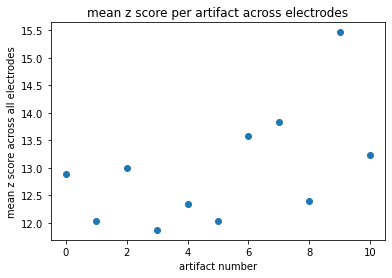

In [99]:
mean_z_score_art
plt.figure()
plt.scatter(range(len(mean_z_score_art)),mean_z_score_art)
plt.title('mean z score per artifact across electrodes')
plt.ylabel('mean z score across all electrodes')
plt.xlabel('artifact number')

In [ ]:
mean_amp_art=[]
for ix in range(len(above_both)):
    all_amp_el_0=[]
    for electrode in range(data.shape[0]):
        amp = abs(data[electrode,above_both[ix]])
        all_amp_el_0.append(amp)
    mean_amp_art.append(statistics.mean(all_amp_el_0))
    plt.figure()
    plt.scatter(range(len(all_amp_el_0)),all_amp_el_0)
    plt.title(f'amp of 1 artifact across electrodes , artifact # {ix}')
    plt.xlabel('electrode')
    plt.ylabel('amplitude of artifact')

Text(0.5, 0, 'artifact number')

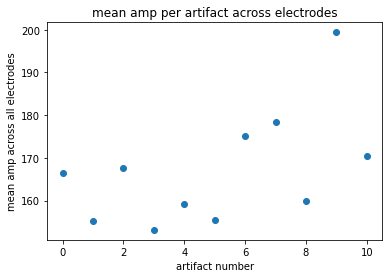

In [103]:
#look at the mean accross electrodes of the ampliotude of each artifact
plt.figure()
plt.scatter(range(len(mean_amp_art)),mean_amp_art)
plt.title('mean amp per artifact across electrodes')
plt.ylabel('mean amp across all electrodes')
plt.xlabel('artifact number')

## What are the average amplitudes and z scores of the artifacts?

In [104]:
mean_of_all_art_amps =statistics.mean(mean_amp_art)
print(mean_of_all_art_amps)

167.3213


In [105]:
mean_of_all_z_arts =statistics.mean(mean_z_score_art)
print(mean_of_all_z_arts)

12.970557


### number of detected artifacts?

In [144]:
num_arts = len(above_both)

## Now want to find how much time was removed from data. Maybe do this using intervals and also valid timestmps to make sure they agree. 

In [106]:
sum(valid_timestamps==-1)

803

In [107]:
interval_list

array([[1.56349063e+09, 1.56349340e+09]])

In [108]:
valid_timestamps

array([1.56349093e+09, 1.56349093e+09, 1.56349093e+09, ...,
       1.56349103e+09, 1.56349103e+09, 1.56349103e+09])

In [110]:
times = get_valid_intervals(valid_timestamps[valid_timestamps != -1], recording.get_sampling_frequency(), 1.5, 0.001)

In [111]:
times

array([[1.56349093e+09, 1.56349094e+09],
       [1.56349094e+09, 1.56349094e+09],
       [1.56349094e+09, 1.56349098e+09],
       [1.56349098e+09, 1.56349098e+09],
       [1.56349098e+09, 1.56349098e+09],
       [1.56349098e+09, 1.56349099e+09],
       [1.56349099e+09, 1.56349101e+09],
       [1.56349101e+09, 1.56349102e+09],
       [1.56349102e+09, 1.56349103e+09]])

In [112]:
times[1][0]
times[0]
    

array([1.56349093e+09, 1.56349094e+09])

In [113]:
times[0][0]

1563490928.974289

In [114]:
times[1][0]-times[0][1]

0.0051000118255615234

In [115]:
0.0020999908447265625*20000

41.99981689453125

In [116]:
#find the time between each set of valid intervals (find out how much time was removed)
time_bet_int=[]
for ix in range(len(times)):
    if ix < (len(times)-1):
        time_bet_int.append(times[ix+1][0]-times[ix][1])
    if ix == len(times): 
        time_bet_int.append(times[ix][0]-times[ix-1][1])

In [117]:
len(times)

9

In [118]:
len(time_bet_int)

8

In [119]:
times[7]

array([1.56349101e+09, 1.56349102e+09])

In [120]:
time_bet_int

[0.0051000118255615234,
 0.005050182342529297,
 0.005049943923950195,
 0.005049943923950195,
 0.005049943923950195,
 0.0051000118255615234,
 0.005050182342529297,
 0.0051000118255615234]

In [121]:
samp_bet_int=[]
for ix in range(len(time_bet_int)):
    samp_bet_int.append(time_bet_int[ix]*recording.get_sampling_frequency())

In [122]:
samp_bet_int

[101.86190476190477,
 100.86666666666667,
 100.86190476190477,
 100.86190476190477,
 100.86190476190477,
 101.86190476190477,
 100.86666666666667,
 101.86190476190477]

In [123]:
total_time_removed = sum(time_bet_int)

In [124]:
total_time_removed

0.04055023193359375

In [125]:
total_samples_removed = sum(samp_bet_int)

In [126]:
print(total_samples_removed)
print(sum(valid_timestamps==-1))

809.9047619047619
803


In [127]:
#hmmmm slightly different values, but probably a rounding problem.  (theres 7 intervals that are decimals, and the intervals are about 7 sasmples different) 
recording.get_sampling_frequency()

19972.876190476192

In [128]:
original_recording_time = times[len(times)-1][1] - times[0][0]

In [129]:
original_recording_time 

99.99991226196289

In [130]:
prop_time_removed = total_time_removed / original_recording_time

In [131]:
prop_time_removed*100
#this is the percent of the recording removed due to artifact 

0.040550267511602504

In [ ]:
#would be itneresting to see how many events cross each threshold on each electrode, and at what point they are considered artifact vs l


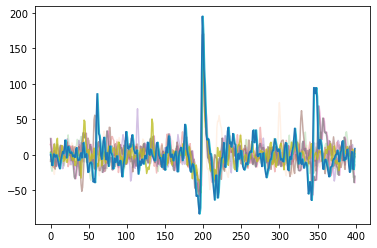

In [135]:
# can plot all tracers from 1 electrode on top of eachotehr
plt.figure()
for ix in range(len(above_both)):
    data_sample = data[0,(above_both[ix]-200):(above_both[ix]+200)]
    plt.plot(data_sample,alpha=ix/10)


#### This section was an initial attempt to compare final intervals with valid timstamps, really not doing anything useful anymore so ill move it to the end  

In [ ]:
# times = get_valid_intervals(valid_timestamps[valid_timestamps != -1], recording.get_sampling_frequency(), 1.5, 0.001)

# times[1][1]-times[1][0]

# times[0]
# time1=times[0][0]
# time2=times[0][1]

# data1=data[3]

# for electrode in range(0,96):
#     plt.figure()
#     plt.plot(above_z[electrode])
#     plt.title(f'times when z score thresh is crossed for electrode {electrode} with zscore thresh = {zscore_thresh}')
#     plt.xlabel('time')
#     plt.ylabel('z score thresh crossed')

# data[0,above_both[0]]

# data1[100]
# time1

# plt.plot(data1)

# plt.plot(data[0])

# data1[above_both]=0

# len(data1[valid_timestamps !=-1]) #How many samples are valid?

# len(data1)-len(data1[valid_timestamps !=-1]) #How many samples were removed?

# len(data1) #How many samples were there originally?

# data1[int(time1/20000)]

# data1=data[2]

# data1.shape

# plt.plot(data1[valid_timestamps ==-1])

# valid = (valid_timestamps[valid_timestamps !=-1])

# data.shape[0]

#plot amplitude after artifact removal
# for ix in range(data.shape[0]):
#     data1=data[ix]
#     plt.figure()
#     plt.plot(data1[valid_timestamps !=-1])
#     plt.title(f'electrode {ix}')


# lets plot only the artfact times across electrodes

# above_both #to get an idea of how many artifacts were detected, also not if they are back to back 

## The goal of this next section was to look at all times when amp thresh crosses to compare non artifact to artifact

In [54]:
# # Lets make a section to find when the amplitude crosses threshold on 1 electrode. then plot all those tmies on different electrodes to see why they werent detected 

# electrode1 = data[0,]

# above_a1 = np.abs(electrode1) > amplitude_thresh

# # above_both = np.ravel(np.argwhere(np.sum(np.logical_and(above_z, above_a1), axis=0) >= nelect_above))





In [61]:
# print(electrode1[above_a1])
# print(above_both)


[161.30424 161.64917 168.55257 154.32303 153.33463 168.8596  169.98402
 155.99782 178.21094 195.04015 168.52687]
[ 223839  223840  230775  368039 1019493 1031364 1090675 1173293 1242141
 1242142 1644722 1858867 1858868 1997065]


In [ ]:
# plt.plot(electrode1)

In [183]:
# electrode1_cross_amp

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])

In [62]:
# 161*20000

3220000

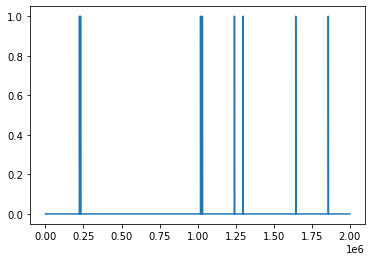

In [63]:
# plt.plot(above_a1)

In [2]:
# %matplotlib widget


# ix = 0 #which electrode you would like to plot
# plt.figure()
# data_1_row = data[ix,]
# plt.plot(data_1_row)
# plt.title(f'electrode {ix},\n{session_data} \n {artifact_params}')
# plt.ylabel('amplitude')
# plt.xlabel('sample')
# for a in above_a1:
#     plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)
# # plt.hlines(amplitude_thresh,0,650000)
# # plt.hlines(-1*amplitude_thresh,0,650000)

In [1]:
# for a in above_a1:
#     plt.axvspan(int(a - half_window_points),int(a + half_window_points), color='red', alpha=0.5)

In [ ]:
above_a1

In [ ]:
#should find mean of signal, and all relative z scores in terms of amplitude 

In [53]:
data1 = data[0,]

In [57]:
import statistics
statistics.mean(data1)

-0.000111080946

In [ ]:
z_scores = 1:15


In [63]:
dataz = np.abs(stats.zscore(data1))

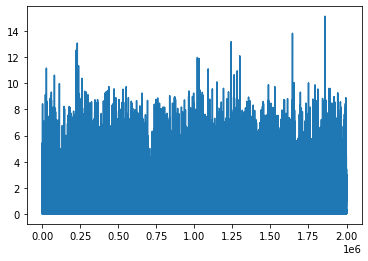

In [67]:
%matplotlib inline
plt.plot(dataz)

In [65]:
print(dataz)

[1.7872705  0.8673771  0.36709246 ... 1.6570222  2.7918694  1.0355918 ]


In [72]:
statistics.mean(dataz)

0.7528651